In [340]:
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
#import sc_toolbox

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [5]:
import anndata

In [341]:
%%R
library(edgeR)
#library(MAST)

In [353]:
adata = sc.read('all_nk_cells.h5ad')

In [355]:
adata.obs['label'] = adata.obs['reference']

In [356]:
adata.obs['replicate'] = [f'{x}_{y}' for x,y in zip(adata.obs['dataset'],adata.obs['source'])]

In [357]:
adata.obs['cell_type'] = adata.obs['lower_res_subset']

In [359]:
adata.layers["counts"] = adata.X.copy()

In [360]:
adata.obs['replicate'] = adata.obs['replicate'].astype('category')

In [362]:
adata

AnnData object with n_obs × n_vars = 89604 × 11866
    obs: 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'sample', 'batch', 'subset', 'dataset', 'source', 'tumor_type', 'label', '_scvi_batch', '_scvi_labels', 'subset_source', 'subset_only', 'source_only', 'low_res_subset', 'low_res_subset_source', 'lower_res_subset', 'Tissue residency_auc', 'reference', 'reference_subset', 'replicate', 'cell_type'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'low_res_subset_colors', 'neighbors', 'paga', 'source_colors', 'subset_colors', 'subset_only_colors', 'subset_only_sizes', 'subset_source_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [363]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 89216 × 11866
    obs: 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'sample', 'batch', 'subset', 'dataset', 'source', 'tumor_type', 'label', '_scvi_batch', '_scvi_labels', 'subset_source', 'subset_only', 'source_only', 'low_res_subset', 'low_res_subset_source', 'lower_res_subset', 'Tissue residency_auc', 'reference', 'reference_subset', 'replicate', 'cell_type', 'n_genes'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'low_res_subset_colors', 'neighbors', 'paga', 'source_colors', 'subset_colors', 'subset_only_colors', 'subset_only_sizes', 'subset_source_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [364]:
adata.obs["sample"] = [
    f"{rep}_{l}" for rep, l in zip(adata.obs["replicate"], adata.obs["label"])
]

In [365]:
adata.obs["replicate"] = adata.obs["replicate"].astype("category")
adata.obs["label"] = adata.obs["label"].astype("category")
adata.obs["sample"] = adata.obs["sample"].astype("category")
adata.obs["cell_type"] = adata.obs["cell_type"].astype("category")

In [366]:
NUM_OF_CELL_PER_DONOR = 10

def aggregate_and_filter(
    adata,
    cell_identity,
    donor_key="sample",
    condition_key="label",
    cell_identity_key="cell_type",
    obs_to_keep=[],  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=2,
):
    # subset adata to the given cell identity
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
    size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
    donors_to_drop = [
        donor
        for donor in size_by_donor.index
        if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
    ]
    if len(donors_to_drop) > 0:
        print("Dropping the following samples:")
        print(donors_to_drop)
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        print(f"\tProcessing donor {i+1} out of {len(donors)}...", end="\r")
        if donor not in donors_to_drop:
            adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
            # create replicates for each donor
            indices = list(adata_donor.obs_names)
            random.shuffle(indices)
            indices = np.array_split(np.array(indices), replicates_per_patient)
            for i, rep_idx in enumerate(indices):
                adata_replicate = adata_donor[rep_idx]
                # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
                agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
                for obs in obs_to_keep:
                    agg_dict[obs] = "first"
                # create a df with all genes, donor and condition info
                df_donor = pd.DataFrame(adata_replicate.X.A)
                df_donor.index = adata_replicate.obs_names
                df_donor.columns = adata_replicate.var_names
                df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
                # aggregate
                df_donor = df_donor.groupby(donor_key).agg(agg_dict)
                df_donor[donor_key] = donor
                df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]
    print("\n")
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
    )
    return adata_cell_pop

In [314]:
%%R
fit_model <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)$label)
    # filter out genes with low counts
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y, min.count = 5)
    #y <- y[keep, , keep.lib.sizes=FALSE]
    y <- y[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    # normalize
    y <- calcNormFactors(y)
    # create a vector that is concatentation of condition and cell type that we will later use with contrasts
    group <- paste0(colData(adata_)$label, ".", colData(adata_)$cell_type)
    replicate <- colData(adata_)$replicate
    #print(group)
    #print(replicate)
    # create a design matrix: here we have multiple donors so also consider that in the design matrix
    design <- model.matrix(~ 0 + group + replicate)
    # estimate dispersion
    y <- estimateDisp(y, design = design)
    # fit the model
    #print(design)
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}

In [367]:
obs_to_keep = ["label", "cell_type", "replicate", "sample"]

In [368]:
adata.X = adata.layers["counts"].copy()

In [371]:
# process first cell type separately...
cell_type = adata.obs["cell_type"].cat.categories[0]
print(
    f'Processing {cell_type} (1 out of {len(adata.obs["cell_type"].cat.categories)})...'
)
adata_pb = aggregate_and_filter(adata, cell_type, obs_to_keep=obs_to_keep)
for i, cell_type in enumerate(adata.obs["cell_type"].cat.categories[1:]):
    print(
        f'Processing {cell_type} ({i+2} out of {len(adata.obs["cell_type"].cat.categories)})...'
    )
    adata_cell_type = aggregate_and_filter(adata, cell_type, obs_to_keep=obs_to_keep)
    adata_pb = adata_pb.concatenate(adata_cell_type)

Processing CD56bright (1 out of 2)...
Dropping the following samples:
['bhaduri_glioblastoma_tumor_query', 'damsky_skin_normal_reference', 'mathewson_glioblastoma_tumor_query', 'rindler_skin_normal_reference', 'xue_skin_normal_reference']
	Processing donor 58 out of 58...

Processing CD56dim (2 out of 2)...
Dropping the following samples:
['bhaduri_glioblastoma_tumor_query', 'he_skin_normal_reference', 'johnson_glioblastoma_tumor_query', 'xie_glioblastoma_tumor_query', 'xu_GSE158399_breast_tumor_query', 'xu_GSE180286_breast_tumor_query', 'xue_skin_normal_reference']
	Processing donor 61 out of 61...



/home/ubuntu/miniconda3/envs/scenic/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [318]:
adata_pb.layers['counts'] = adata_pb.X.copy()

In [319]:
sc.pp.normalize_total(adata_pb, target_sum=1e6)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

In [374]:
adata_pb.obs

,label,cell_type,replicate,sample,batch
donor_GSE212966_pancreas_tumor_query_0-0,query,CD56bright,GSE212966_pancreas_tumor,GSE212966_pancreas_tumor_query,0
donor_GSE212966_pancreas_tumor_query_1-0,query,CD56bright,GSE212966_pancreas_tumor,GSE212966_pancreas_tumor_query,0
donor_abdelfattah_glioblastoma_tumor_query_0-0,query,CD56bright,abdelfattah_glioblastoma_tumor,abdelfattah_glioblastoma_tumor_query,0
donor_abdelfattah_glioblastoma_tumor_query_1-0,query,CD56bright,abdelfattah_glioblastoma_tumor,abdelfattah_glioblastoma_tumor_query,0
donor_amir_PBMC_reference_0-0,reference,CD56bright,amir_PBMC,amir_PBMC_reference,0
...,...,...,...,...,...
donor_zhang_melanoma_tumor_query_1-1,query,CD56dim,zhang_melanoma_tumor,zhang_melanoma_tumor_query,1
donor_zhou_sarcoma_tumor_query_0-1,query,CD56dim,zhou_sarcoma_tumor,zhou_sarcoma_tumor_query,1
donor_zhou_sarcoma_tumor_query_1-1,query,CD56dim,zhou_sarcoma_tumor,zhou_sarcoma_tumor_query,1
donor_zilionis_lung_tumor_query_0-1,query,CD56dim,zilionis_lung_tumor,zilionis_lung_tumor_query,1


In [321]:
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1)
adata_pb.obs["lib_size"] = adata_pb.obs['lib_size'].astype(int)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

In [323]:
adata_pb.X = adata_pb.layers['counts'].copy()

In [372]:
adata_pb.X = adata_pb.X.astype(float)

In [350]:
adata_bright = adata_pb[adata_pb.obs["cell_type"] == "CD56bright"]
adata_bright

View of AnnData object with n_obs × n_vars = 50 × 11866
    obs: 'label', 'cell_type', 'replicate', 'sample', 'batch'

In [349]:
adata_pb.write('/tumor-data/adata_pb_psuedobulk_deg_filtered_new_replicates_2.h5ad')

In [328]:
#adata_bright.write('/tumor-data/adata_bright_psuedobulk_deg_filtered.h5ad')

In [8]:
#adata_bright = sc.read('/tumor-data/adata_bright_psuedobulk_deg.h5ad')

In [329]:
#adata_bright.obs = adata_bright.obs[['label', 'cell_type', 'replicate', 'sample', 'batch']]

In [83]:
#adata_bright[adata_bright.obs['replicate'] == 'p032n_bischoff']

In [ ]:
%%time
%%R -i adata_pb
outs <-fit_model(adata_pb)

In [28]:
#adata_bright[adata_bright.obs['label'] == 'reference'].obs

In [ ]:
%%time
%%R -i adata_bright
outs <-fit_model(adata_bright)

In [43]:
%%R
fit <- outs$fit
y <- outs$y

In [47]:
%%R -o tt
myContrast <- makeContrasts("groupquery.CD56bright-groupreference.CD56bright", levels = y$design)
qlf <- glmQLFTest(fit, contrast=myContrast)
# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt <- topTags(qlf, n = Inf)
tt <- tt$table

In [48]:
tt.shape

(4287, 5)

In [112]:
adata_bright.var_names

Index(['LINC00115', 'FAM41C', 'SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'PERM1',
       'HES4', 'ISG15', 'AGRN',
       ...
       'COL6A1', 'COL6A2', 'SPATC1L', 'LSS', 'MCM3AP', 'YBEY', 'PCNT', 'DIP2A',
       'S100B', 'PRMT2'],
      dtype='object', length=14007)

In [101]:
np.sum(tt['logFC']<-1)

5

In [50]:
tt[:5]

,logFC,logCPM,F,PValue,FDR
HSPB1,1.629049,9.115354,130.293815,1.021213e-21,4.377940e-18
CD52,1.057410,11.011954,121.408115,1.073750e-20,2.301583e-17
DNAJB4,1.843030,6.853964,97.985342,9.077860e-18,1.297226e-14
HSPH1,1.582062,9.265924,86.979542,2.269969e-16,2.380624e-13
CACYBP,1.159112,8.602548,85.911879,3.167364e-16,2.380624e-13


In [51]:
tt.sort_values('logFC', ascending=False).index[:10]

Index(['SERPINH1', 'GEM', 'HSPA6', 'ID3', 'CCR7', 'DNAJB4', 'HSPA1A', 'HSPB1',
       'HSPH1', 'DNAJA4'],
      dtype='object')

In [52]:
tt.sort_values('logFC', ascending=True).index[:10]

Index(['S1PR5', 'SPON2', 'MYBL1', 'IRF8', 'TGFBR3', 'RAB9A', 'GSAP', 'CD160',
       'LPCAT1', 'FCGR3A'],
      dtype='object')

In [53]:
%%R
tr <- glmTreat(fit, contrast=myContrast, lfc=1.5)
print(head(topTags(tr)))

Coefficient:  1*groupquery.CD56bright -1*groupreference.CD56bright 
             logFC unshrunk.logFC   logCPM       PValue FDR
GEM       2.333793       2.358211 7.070913 0.0007836103   1
SERPINH1  2.380476       2.424094 6.349110 0.0009413291   1
S1PR5    -2.008020      -2.028434 6.002821 0.0037262353   1
HSPA6     2.067731       2.072520 9.176974 0.0067119403   1
ID3       1.959304       1.968982 7.867123 0.0078499084   1
DNAJB4    1.843030       1.858080 6.853964 0.0133592371   1


In [ ]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR<0.01)])

In [ ]:
%%time
%%R -i adata_pb
outs <-fit_model(adata_pb)

In [331]:
%%R
fit <- outs$fit
y <- outs$y

In [332]:
%%R -i adata_pb -o de_per_cell_type
de_per_cell_type <- list()
for (cell_type in unique(colData(adata_pb)$cell_type)) {
    print(cell_type)
    # create contrast for this cell type
    myContrast <- makeContrasts(paste0("groupquery.", cell_type, "-groupreference.", cell_type), levels = y$design)
    # perform QLF test
    qlf <- glmQLFTest(fit, contrast=myContrast)
    # get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
    tt <- topTags(qlf, n = Inf)
    # save in the list with the results for all the cell types
    de_per_cell_type[[cell_type]] <- tt$table
}

[1] "CD56bright"


/home/ubuntu/miniconda3/envs/scenic/lib/python3.9/site-packages/anndata2ri/py2r.py:37: NotConvertedWarning: Conversion 'py2rpy' not defined for objects of type '<class 'NoneType'>'
  warn(str(e), NotConvertedWarning)


[1] "CD56dim"


In [333]:
import sc_toolbox

In [334]:
# get cell types that we ran the analysis for
cell_types = de_per_cell_type.keys()
# add the table to .uns for each cell type
for cell_type in cell_types:
    df = de_per_cell_type[cell_type]
    df["gene_symbol"] = df.index
    df["cell_type"] = cell_type
    sc_toolbox.tools.de_res_to_anndata(
        adata,
        df,
        groupby="cell_type",
        score_col="logCPM",
        pval_col="PValue",
        pval_adj_col="FDR",
        lfc_col="logFC",
        key_added="edgeR_" + cell_type,
    )
    df.to_csv(f"de_edgeR_{cell_type}_new_replicates.csv")

In [335]:
adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

In [336]:
cd56bright_deg_df = sc.get.rank_genes_groups_df(adata, group="CD56bright", key="edgeR_CD56bright").copy()


In [337]:
cd56dim_deg_df = sc.get.rank_genes_groups_df(adata, group="CD56dim", key="edgeR_CD56dim").copy()


In [ ]:
cd56bright_deg_df.sort_values('logfoldchanges', ascending=True)#.index[:10]

In [ ]:
cd56_deg_df.sort_values('logfoldchanges', ascending=True)#.index[:10]

In [215]:
from bioinfokit import analys, visuz


In [245]:
show_now=False

In [218]:
cd56bright_deg_df["pvals_adj"] = cd56bright_deg_df["pvals_adj"].astype("float")

In [223]:
cd56dim_deg_df["pvals_adj"] = cd56dim_deg_df["pvals_adj"].astype("float")

In [237]:
LOG_FOLD_CHANGE

1.5

In [246]:
visuz.GeneExpression.volcano(df=cd56bright_deg_df, lfc='logfoldchanges', pv='pvals_adj', 
                             show=show_now, geneid='names', axtickfontname='DejaVu Sans',
                             genenames=tuple(cd56bright_deg_df[(np.abs(cd56bright_deg_df['logfoldchanges']) > 1.5)&(cd56bright_deg_df['pvals_adj']<0.05)]['names']),
                             gstyle=1, lfc_thr=(1.5, 1.5), pv_thr=(0.05, 0.05), figname=f'cd56bright_deg_all', figtype='svg')

findfont: Font family 'Arial' not found.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


In [247]:
visuz.GeneExpression.volcano(df=cd56dim_deg_df, lfc='logfoldchanges', pv='pvals_adj', 
                             show=show_now, geneid='names', axtickfontname='DejaVu Sans',
                             genenames=tuple(cd56dim_deg_df[(np.abs(cd56dim_deg_df['logfoldchanges']) > 1.5)&
                                                            (cd56dim_deg_df['pvals_adj']<0.05)]['names']),
                             #color=('grey', "blue", "green"),
                             gstyle=1, lfc_thr=(1.5, 1.2), pv_thr=(0.05, 0.05), figname=f'cd56dim_deg_all', figtype='svg')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


/home/ubuntu/miniconda3/envs/scenic/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


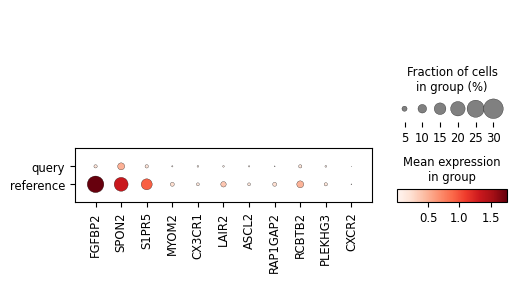

In [231]:
sc.pl.dotplot(adata[adata.obs['lower_res_subset'] == 'CD56bright'], 
              cd56bright_deg_df[(cd56bright_deg_df['logfoldchanges'] < -LOG_FOLD_CHANGE)&(cd56bright_deg_df['pvals_adj'] < 0.05)]['names'], 
              groupby='reference', save=f'cd56bright_all_tissues_down_in_query.pdf')

/home/ubuntu/miniconda3/envs/scenic/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


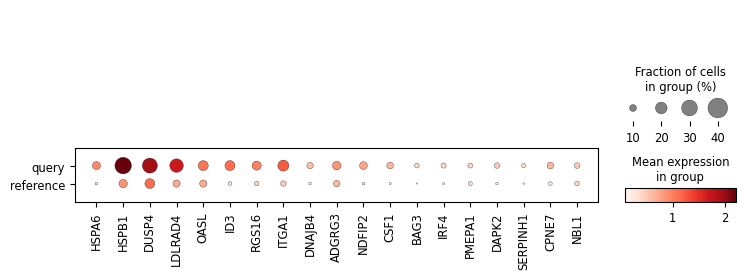

In [232]:
sc.pl.dotplot(adata[adata.obs['lower_res_subset'] == 'CD56bright'], 
              cd56bright_deg_df[(cd56bright_deg_df['logfoldchanges'] > LOG_FOLD_CHANGE) & (cd56bright_deg_df['pvals_adj'] < 0.05)]['names'],#[:10], 
              groupby='reference', save=f'cd56bright_all_tissues_up_in_query.pdf')

In [1009]:
#sc.pl.dotplot(adata[adata.obs['lower_res_subset'] == 'CD56dim'], 
#              cd56dim_deg_df[cd56dim_deg_df['logfoldchanges'] < -LOG_FOLD_CHANGE]['names'], 
#              groupby='source')#, save='cd56dim_top_fc_up_in_query.pdf')

/home/ubuntu/miniconda3/envs/scenic/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


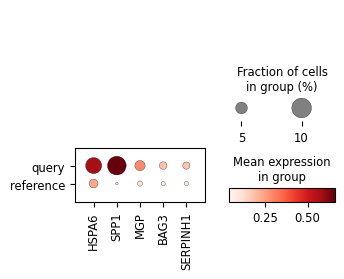

In [233]:
sc.pl.dotplot(adata[adata.obs['lower_res_subset'] == 'CD56dim'], 
              cd56dim_deg_df[(cd56dim_deg_df['logfoldchanges'] > LOG_FOLD_CHANGE) & (cd56dim_deg_df['pvals_adj'] < 0.05)]['names'],#[:10], 
              groupby='reference', save=f'cd56dim_all_tissues_up_in_query.pdf')

/home/ubuntu/miniconda3/envs/scenic/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


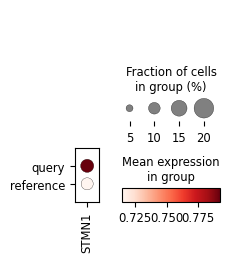

In [238]:
sc.pl.dotplot(adata[adata.obs['lower_res_subset'] == 'CD56dim'], 
              cd56dim_deg_df[(cd56dim_deg_df['logfoldchanges'] < -1.2) & (cd56dim_deg_df['pvals_adj'] < 0.05)]['names'],#[:10], 
              groupby='reference', save=f'cd56dim_all_tissues_down_in_query.pdf')

In [156]:
import os

In [157]:
FDR = 0.05
LOG_FOLD_CHANGE = 1.5


def volcano_plot(adata, group_key, group_name="cell_type", groupby="label", title=None):
    cell_type = "_".join(group_key.split("_")[1:])
    result = sc.get.rank_genes_groups_df(adata, group=cell_type, key=group_key).copy()
    result["-logQ"] = -np.log(result["pvals"].astype("float"))
    lowqval_de = result.loc[abs(result["logfoldchanges"]) > LOG_FOLD_CHANGE]
    other_de = result.loc[abs(result["logfoldchanges"]) <= LOG_FOLD_CHANGE]

    fig, ax = plt.subplots()
    sns.regplot(
        x=other_de["logfoldchanges"],
        y=other_de["-logQ"],
        fit_reg=False,
        scatter_kws={"s": 6},
    )
    sns.regplot(
        x=lowqval_de["logfoldchanges"],
        y=lowqval_de["-logQ"],
        fit_reg=False,
        scatter_kws={"s": 6},
    )
    ax.set_xlabel("log2 FC")
    ax.set_ylabel("-log Q-value")

    if title is None:
        title = group_key.replace("_", " ")
    plt.title(title)
    plt.savefig(os.path.join(figures_dir, f'{group_key}_tumor_vs_ref.pdf'))

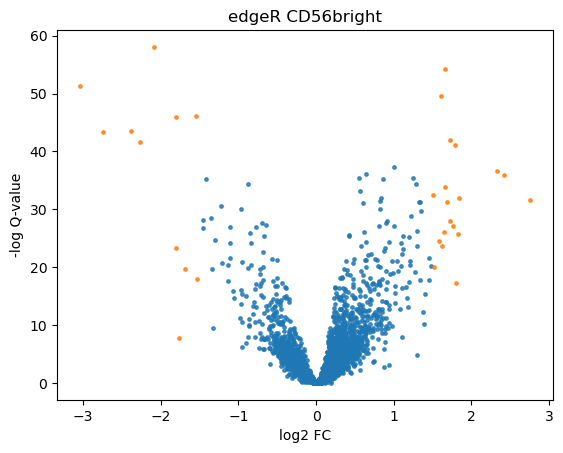

In [221]:
volcano_plot(adata, "edgeR_CD56bright")

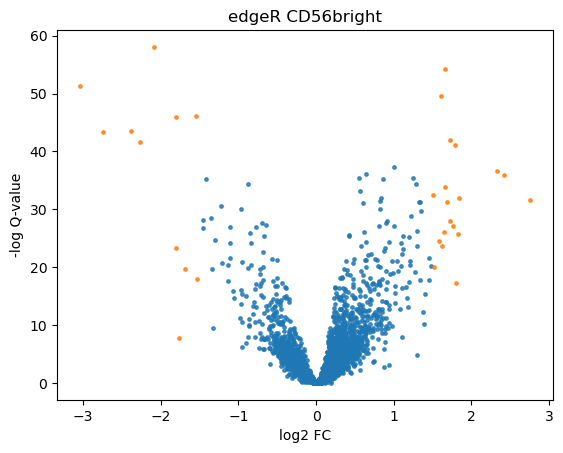

In [159]:
volcano_plot(adata, "edgeR_CD56bright")

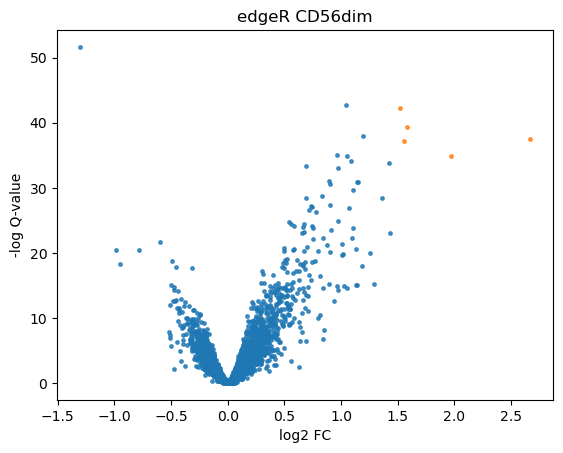

In [160]:
volcano_plot(adata, "edgeR_CD56dim")

/home/ubuntu/miniconda3/envs/scenic/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


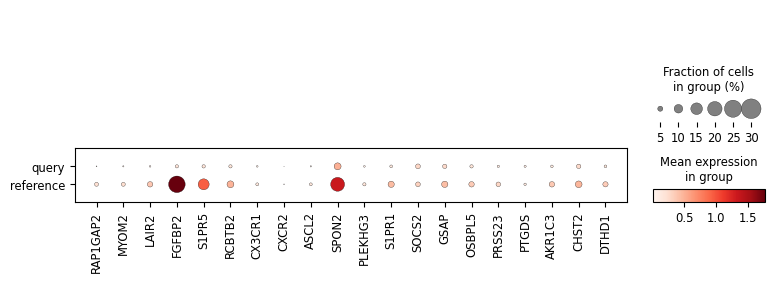

In [161]:
sc.pl.dotplot(adata[adata.obs['lower_res_subset'] == 'CD56bright'], 
              cd56bright_deg_df.sort_values('logfoldchanges', ascending=True)['names'][:20], 
              groupby='reference', save='cd56bright_top_fc_down_in_query_top_20.pdf')

/home/ubuntu/miniconda3/envs/scenic/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


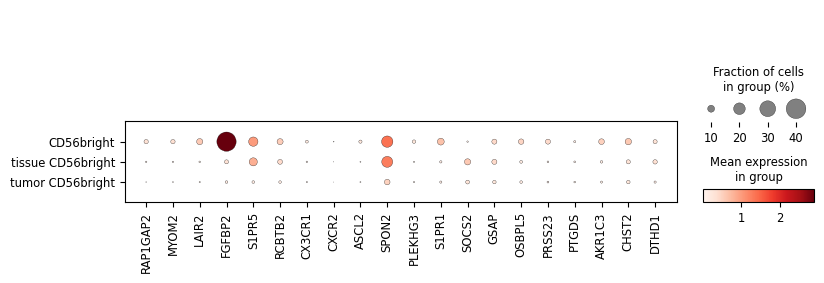

In [198]:
sc.pl.dotplot(adata[adata.obs['lower_res_subset'] == 'CD56bright'], 
              cd56bright_deg_df.sort_values('logfoldchanges', ascending=True)['names'][:20], 
              groupby='low_res_subset', save='cd56bright_top_fc_down_in_query_top_20_pb_tissue.pdf')

/home/ubuntu/miniconda3/envs/scenic/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


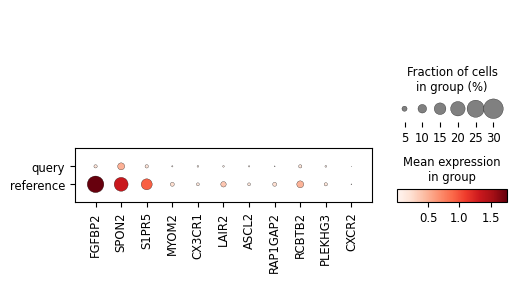

In [162]:
sc.pl.dotplot(adata[adata.obs['lower_res_subset'] == 'CD56bright'], 
              cd56bright_deg_df[cd56bright_deg_df['logfoldchanges'] < -LOG_FOLD_CHANGE]['names'], 
              groupby='reference', save='cd56bright_top_fc_down_in_query.pdf')

/home/ubuntu/miniconda3/envs/scenic/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


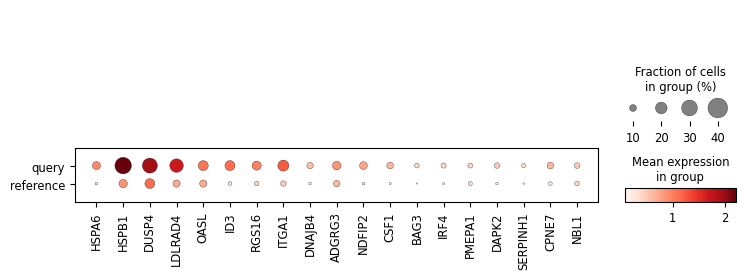

In [163]:
sc.pl.dotplot(adata[adata.obs['lower_res_subset'] == 'CD56bright'], 
              cd56bright_deg_df[cd56bright_deg_df['logfoldchanges'] > LOG_FOLD_CHANGE]['names'], 
              groupby='reference', save='cd56bright_top_fc_up_in_query.pdf')

/home/ubuntu/miniconda3/envs/scenic/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


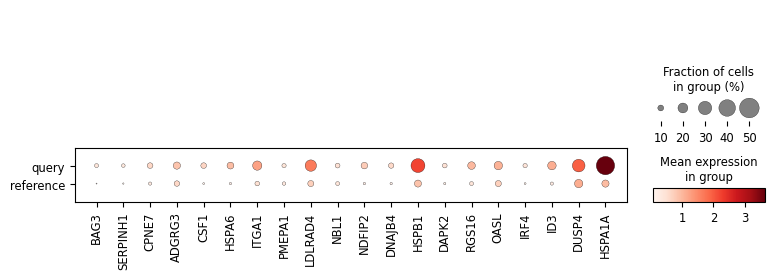

In [164]:
sc.pl.dotplot(adata[adata.obs['lower_res_subset'] == 'CD56bright'], 
              cd56bright_deg_df.sort_values('logfoldchanges', ascending=False)['names'][:20], 
              groupby='reference', save='cd56bright_top_fc_up_in_query_top_20.pdf')

/home/ubuntu/miniconda3/envs/scenic/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


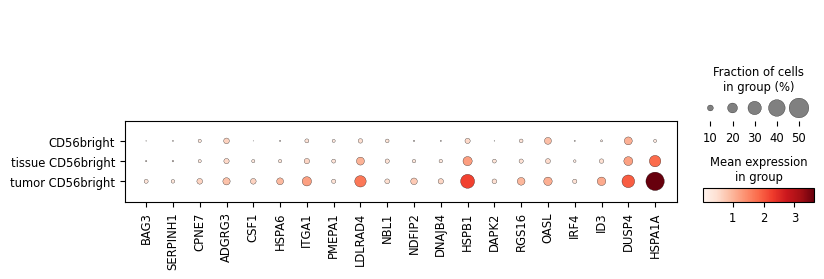

In [168]:
sc.pl.dotplot(adata[adata.obs['lower_res_subset'] == 'CD56bright'], 
              cd56bright_deg_df.sort_values('logfoldchanges', ascending=False)['names'][:20], 
              groupby='low_res_subset', save='cd56bright_top_fc_up_in_query_top_20_pb_tissue.pdf')

/home/ubuntu/miniconda3/envs/scenic/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


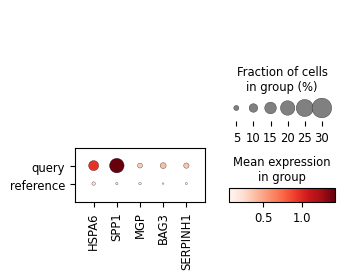

In [165]:
sc.pl.dotplot(adata[adata.obs['lower_res_subset'] == 'CD56bright'], 
              cd56dim_deg_df[cd56dim_deg_df['logfoldchanges'] > LOG_FOLD_CHANGE]['names'], 
              groupby='reference', save='cd56dim_top_fc_up_in_query.pdf')

/home/ubuntu/miniconda3/envs/scenic/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


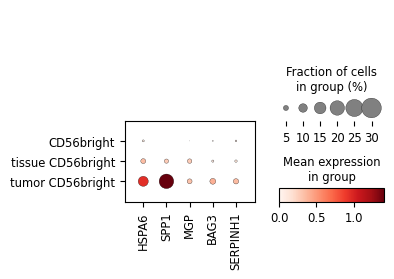

In [167]:
sc.pl.dotplot(adata[adata.obs['lower_res_subset'] == 'CD56bright'], 
              cd56dim_deg_df[cd56dim_deg_df['logfoldchanges'] > LOG_FOLD_CHANGE]['names'], 
              groupby='low_res_subset', save='cd56dim_top_fc_up_in_query_pb_tissue.pdf')

In [10]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv(f"de_edgeR_CD56bright.csv", index_col=0)

In [11]:
df['rank'] = df['logFC']*-np.log10(df['PValue'])

In [18]:
df.sort_values('rank', ascending=False)

,logFC,logCPM,F,PValue,FDR,gene_symbol,cell_type,rank
HSPB1,1.657317,8.482706,126.386221,2.976738e-24,8.424168e-21,HSPB1,CD56bright,38.990480
BAG3,2.759031,5.622985,66.298052,1.815432e-14,3.805683e-12,BAG3,CD56bright,37.911904
SERPINH1,2.423607,5.432034,76.951403,2.543901e-16,9.598986e-14,SERPINH1,CD56bright,37.794946
CPNE7,2.333649,5.249929,79.840193,1.159705e-16,5.049178e-14,CPNE7,CD56bright,37.188219
OASL,1.607860,6.811432,114.101724,2.945612e-22,4.168041e-19,OASL,CD56bright,34.618555
...,...,...,...,...,...,...,...,...
FGFBP2,-2.262078,10.465962,91.594032,8.721630e-19,4.936443e-16,FGFBP2,CD56bright,-40.851782
LAIR2,-2.376469,7.535845,97.016546,1.223593e-19,9.719908e-17,LAIR2,CD56bright,-44.944645
MYOM2,-2.739198,8.106885,96.701196,1.373839e-19,9.719908e-17,MYOM2,CD56bright,-51.666924
S1PR5,-2.081913,8.132517,138.910507,6.084068e-26,3.443582e-22,S1PR5,CD56bright,-52.497124


In [22]:
df.sort_values('rank', ascending=False)['rank'].to_csv('de_cd56bright_rank.rnk', header=False, sep='\t')

In [23]:
df_dim = pd.read_csv(f"de_edgeR_CD56dim.csv", index_col=0)

In [24]:
df_dim['rank'] = df_dim['logFC']*-np.log10(df_dim['PValue'])

In [26]:
df_dim.sort_values('rank', ascending=False)['rank'].to_csv('de_cd56dim_rank.rnk', header=False, sep='\t')